# Initialization

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bs4
import requests
from collections import defaultdict
from functools import reduce
%matplotlib inline

file_opioids = 'opioids.csv'
file_overdoses = 'overdoses.csv'
file_prescribers = 'prescriber-info.csv'
file_unemployment = 'state_unemployment_2013.csv'

# cosmetics for plots 
sns.set(font_scale = 1.5)

In [2]:
opioids = pd.read_csv(file_opioids)
overdoses = pd.read_csv(file_overdoses)
prescribers = pd.read_csv(file_prescribers)
unemployment = pd.read_csv(file_unemployment, index_col='State')

Data Sources: 
Opioid, overdose, and prescriber dataframes come from [US Opioid Prescriptions/Overdoses](https://www.kaggle.com/apryor6/us-opiate-prescriptions) Kaggle dataset.

Unemployment dataframe is from the [US Bureau of Labor Statistics](https://www.bls.gov/lau/lastrk13.htm)

### A few small cleaning tasks. 

In [3]:
overdoses = overdoses.set_index('State')
overdoses['Population']=overdoses['Population'].str.replace(',', '')
overdoses['Deaths']=overdoses['Deaths'].str.replace(',','')
overdoses[['Population', 'Deaths']]=overdoses[['Population','Deaths']].apply(pd.to_numeric)

# rename column because it's confusing
prescribers= prescribers.rename({'State':'Abbrev'}, axis=1);

# add prescriber information to overdose df 
prescribers_per_state = []
for index, row in overdoses.iterrows(): 
    prescribers_per_state.append(prescribers.loc[prescribers['Abbrev']==row['Abbrev']].shape[0])
overdoses['Prescribers'] = prescribers_per_state

# prescribers per capita
overdoses['Prescribers Per Capita'] = overdoses['Prescribers']/overdoses['Population']
overdoses['Prescribers Per 100,000'] = overdoses['Prescribers Per Capita'] * 100000
# overdoses per capita
overdoses['Deaths Per Capita'] = (overdoses['Deaths']/ overdoses['Population']) 
overdoses['Deaths Per 100,000'] = overdoses['Deaths Per Capita']*100000

# The Data Story

## Introduction: the dataset
The Kaggle US Opioid overdose/prescriber dataset contains the number of overdose deaths by state, as well as information about state population. Prescriber information is also given for a sample of 25,000 unique NPI (National Provider Identifier) numbers, including the number of drugs prescribed for the top 250 most-prescribed drugs in the year 2013. 

The unemployment dataset contains unemployment percentages for individual US states in 2013. 

## Questions 
1. Is the opioid overdose rate the same everywhere, or does it depend on the state? Are there US regions/divisions that are associated with a higher rate of overdose? 
2. Is there really an opioid crisis? 
3. Which variables available in the dataset influence overdose rate? 
4. Can we characterize provider specialties based on the drugs they prescribe in a year?

## Question 1: Is the opioid overdose rate the same everywhere, or does it depend on the geography?

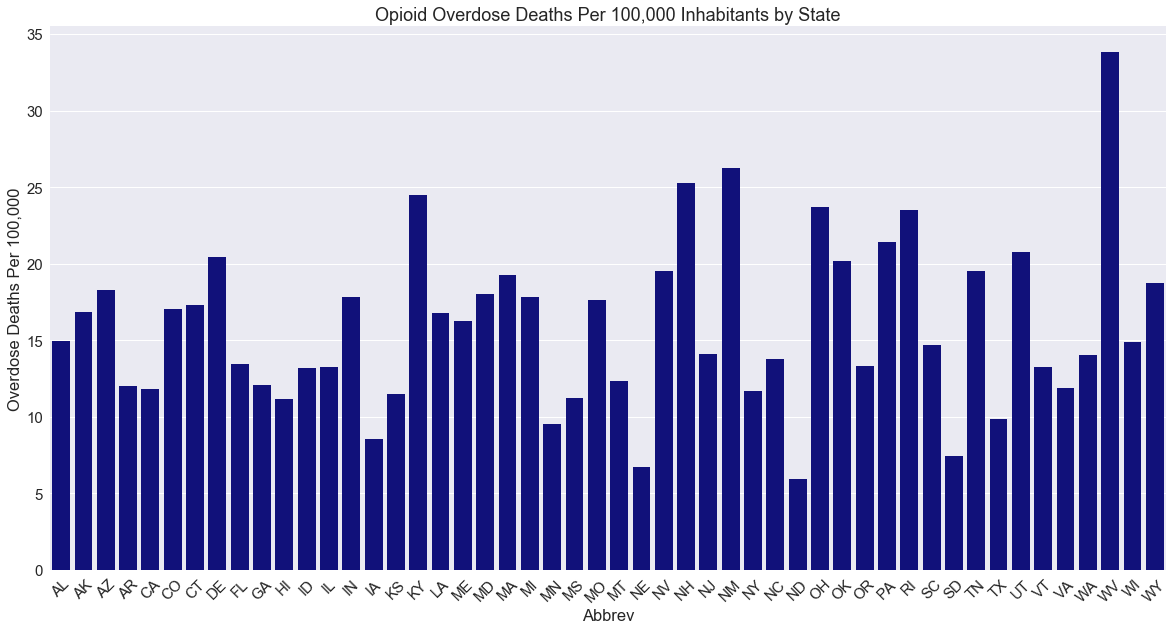

In [4]:
_ = plt.subplots(figsize=(20,10))
dpc_bar = sns.barplot(x = 'Abbrev', y='Deaths Per 100,000', data = overdoses, color = 'darkblue')
_ = dpc_bar.set_xticklabels(overdoses.Abbrev, rotation = 45)
_ = dpc_bar.set_ylabel('Overdose Deaths Per 100,000')
_ = dpc_bar.set_title('Opioid Overdose Deaths Per 100,000 Inhabitants by State')

Overdose deaths per 100,000 interpreted in the following manner. In Alabama, opioid overdose deaths per 100,000 are about 15. This means that for every 100,000 Alabamans, about 15 of them die of opioid overdoses. 

The above bar chart gives a good first overview of how the per capita death rate looks in different states, but it's hard to observe any geographical trends. At first glance, we already see that overdose rate depends strongly on the state. 

We use Plotly to generate a choropleth graph. States with darker coloring have a higher overdose date rate per 10,000 compared to other states. 

In [5]:
import plotly.plotly as py
import pandas as pd

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

overdoses['text'] = overdoses.index + '<br>' + 'Deaths Per 100,000: ' + overdoses[
                    'Deaths Per 100,000'].map(lambda x: np.round(x,2)).astype(str)
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = overdoses['Abbrev'],
        z = overdoses['Deaths Per 100,000'],
        locationmode = 'USA-states',
        text = overdoses['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Per 100,000 Inhabitants")
        ) ]

layout = dict(
        title = '2013 US Opioid Overdose Rate Per 100,000 Inhabitants by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='opioid-overdoses-choropleth-map' )

The choropleth map immediately gives us a better understanding of the geographic layout of opioid overdose rates in the US. The Dakotas, Nebraska, Iowa, Minnesota, and Texas all have relatively low opioid overdose death rates compared to the rest of the country. 

West Virginia stands out as a strong outlier with a very high overdose death rate compared to the rest of the country: anyone who has been following reporting about the US opioid epidemic will be familiar with articles such as [this one](https://www.nytimes.com/interactive/2018/us/west-virginia-opioids.html), which report that communities in West Virginia have the highest opioid overdose rates in the country. 

In [6]:
display_columns = ['Deaths', 'Population','Deaths Per Capita', 'Deaths Per 100,000']
max_deaths = overdoses['Deaths'].max()
max_deaths_per_capita=overdoses['Deaths Per Capita'].max()
min_deaths_per_capita=overdoses['Deaths Per Capita'].min()
print('State With Maximum Opioid Overdose Deaths Per Capita')
print(overdoses.loc[overdoses['Deaths Per Capita']==max_deaths_per_capita][display_columns])
print('-'*100)
print('State With Maximum Number of Opioid Overdose Deaths')
print(overdoses.loc[overdoses['Deaths']==max_deaths][display_columns])
print('-'*100)
print('State With Minimum Opioid Overdose Deaths Per Capita')
print(overdoses.loc[overdoses['Deaths Per Capita']==min_deaths_per_capita][display_columns])
print('-'*100)

State With Maximum Opioid Overdose Deaths Per Capita
               Deaths  Population  Deaths Per Capita  Deaths Per 100,000
State                                                                   
West Virginia     627     1854304           0.000338           33.813226
----------------------------------------------------------------------------------------------------
State With Maximum Number of Opioid Overdose Deaths
            Deaths  Population  Deaths Per Capita  Deaths Per 100,000
State                                                                
California    4521    38332521           0.000118           11.794163
----------------------------------------------------------------------------------------------------
State With Minimum Opioid Overdose Deaths Per Capita
              Deaths  Population  Deaths Per Capita  Deaths Per 100,000
State                                                                  
North Dakota      43      723393           0.000059             5.9

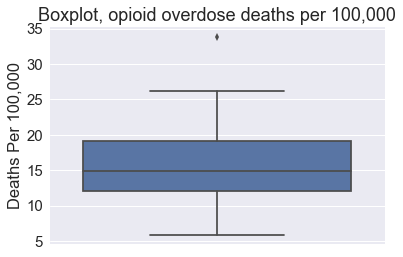

In [7]:
_ = sns.boxplot(y='Deaths Per 100,000', data = overdoses)
_ = plt.title('Boxplot, opioid overdose deaths per 100,000')

In [8]:
overdoses['Deaths Per 100,000'].describe()

count    50.000000
mean     15.943673
std       5.466676
min       5.944210
25%      12.039545
50%      14.905512
75%      19.121418
max      33.813226
Name: Deaths Per 100,000, dtype: float64

Deaths Per 100,000 range from 6 (North Dakota) to 34 (West Virginia). The median number of overdose deaths per 100,000 

The states in the fourth quartile are: 

In [9]:
overdoses.loc[overdoses['Deaths Per 100,000'] > 19.12].index

Index(['Delaware', 'Kentucky', 'Massachusetts', 'Nevada', 'New Hampshire',
       'New Mexico', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Rhode Island',
       'Tennessee', 'Utah', 'West Virginia'],
      dtype='object', name='State')

These states have high overdose death rates relative to their population compared to the median opioid overdose rate. 

From the choropleth map above, it seems like there may be some regions of the US that tend to have a higher opioid overdose rate. We'll explore this further. First, we obtain the US Census bureau-defined regions and divisions for the united states. 

In [10]:
# scrape US Census bureau region/ division information
url_gov = 'https://www2.census.gov/geo/docs/maps-data/maps/reg_div.txt'
regions_req = requests.get(url_gov)
soup_gov = bs4.BeautifulSoup(regions_req.content)
text=soup_gov.p
regions = text.contents[0].split('REGION')[1:]

state_to_reg= dict()
state_to_div = dict()

for row in regions: 
    row_by_div = [s for s in row.split('Division') if s!=''] # split on newlines, take out empty strings
    region_name = row_by_div[0].split(':')[1].strip().strip('*').title()
    div_list = [l.split('\r\n') for l in row_by_div[1:]]
    div_list = [[s for s in l if s!=''] for l in div_list]
    for div in div_list:
        division_name = div[0].split(':')[1].strip()
        for i in div[1:]:
            if i[0]=='*': # skip *Prior to June 1984..." line 
                break
            sep = '('
            state = i.split(sep, 1)[0].strip()
            state_to_reg[state] = region_name
            state_to_div[state] = division_name

In [11]:
overdoses['Region'] = overdoses.index.map(state_to_reg)
overdoses['Division'] = overdoses.index.map(state_to_div)

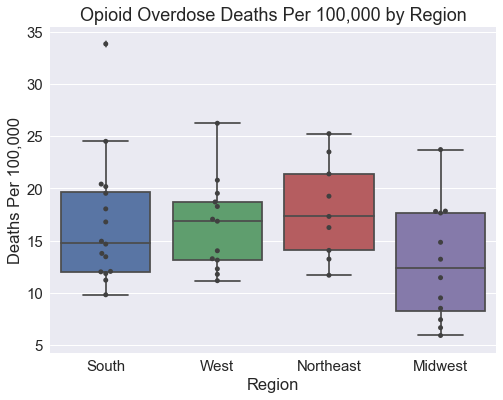

In [12]:
_ = plt.subplots(figsize=(8,6))
dpc_region_boxswarm = sns.boxplot(x='Region', y='Deaths Per 100,000', data = overdoses)
dpc_region_boxswarm = sns.swarmplot(x='Region', y='Deaths Per 100,000', data=overdoses, color = '.25')
_ = dpc_region_boxswarm.set_title('Opioid Overdose Deaths Per 100,000 by Region')

There do appear to be some regional differences. Grouped by region, the summary statistics are: 

In [13]:
overdoses.groupby('Region')['Deaths Per 100,000'].describe()

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Midwest,12.0,12.895233,5.566341,5.944210,8.271081,12.353783,17.691493,23.714852
Northeast,9.0,17.998774,4.699277,11.704163,14.079697,17.324420,21.387526,25.236898
South,16.0,16.701355,6.105784,9.834320,12.059484,14.819271,19.696084,33.813226
West,13.0,16.402324,4.341618,11.181906,13.150255,16.867719,18.707372,26.231401


In [14]:
# utility function to invert dictionaries
def invert_dict(d):
    d_invert = {}
    for k, v in d.items():
        keys = d_invert.setdefault(v, [])
        keys.append(k)
    return d_invert

The states contained in the regions are: 

In [15]:
from textwrap import wrap

for key, state_list in invert_dict(state_to_reg).items(): 
    state_list.sort()
    pr_str_wrapped = wrap('{}: {}, {}'.format(key, ', '.join(state_list[:-1]), state_list[-1]), 80, subsequent_indent = '\t')
    for line in pr_str_wrapped:
        print(line)

Northeast: Connecticut, Maine, Massachusetts, New Hampshire, New Jersey, New
	York, Pennsylvania, Rhode Island, Vermont
Midwest: Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri,
	Nebraska, North Dakota, Ohio, South Dakota, Wisconsin
South: Alabama, Arkansas, Delaware, District of Columbia, Florida, Georgia,
	Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South
	Carolina, Tennessee, Texas, Virginia, West Virginia
West: Alaska, Arizona, California, Colorado, Hawaii, Idaho, Montana, Nevada, New
	Mexico, Oregon, Utah, Washington, Wyoming


There are only four US regions. Each region covers a huge geographical area. Let's see if geographical differences are more apparent if we switch to divisions, which contain a smaller amount of states each. 

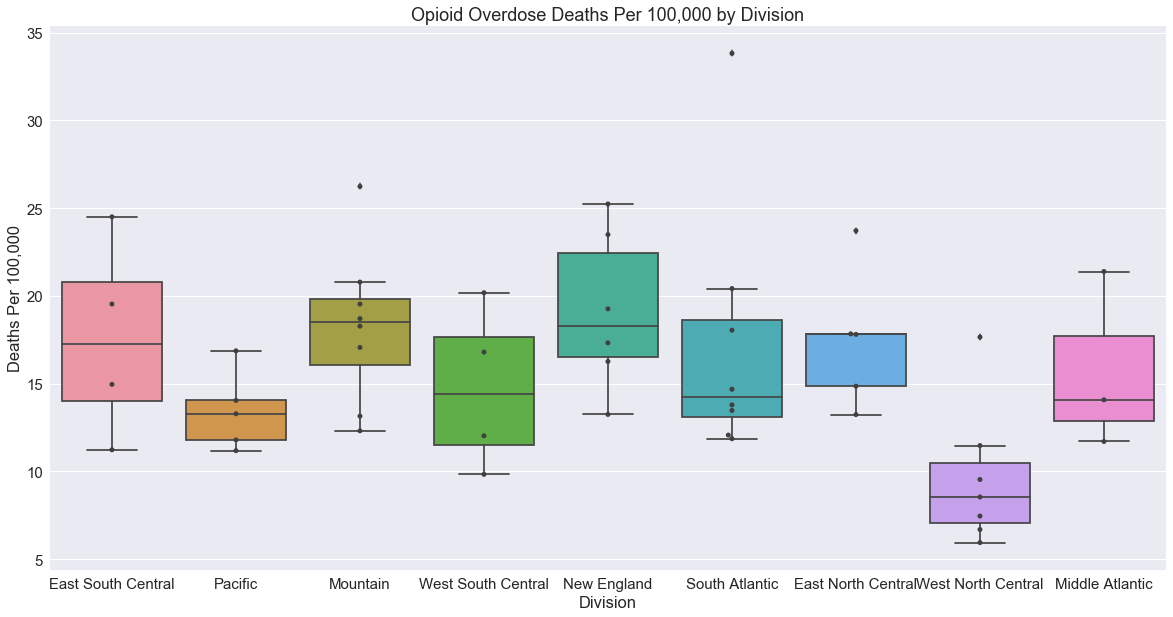

In [16]:
_ = plt.subplots(figsize=(20,10))
dpc_region_boxswarm = sns.boxplot(x='Division', y='Deaths Per 100,000', data = overdoses)
dpc_region_boxswarm = sns.swarmplot(x='Division', y='Deaths Per 100,000', data=overdoses, color = '.25')
_ = dpc_region_boxswarm.set_title('Opioid Overdose Deaths Per 100,000 by Division')

The states contained in each division are: 

In [17]:
for key, state_list in invert_dict(state_to_div).items(): 
    state_list.sort()
    pr_str_wrapped = wrap('{}: {}, {}'.format(key, ', '.join(state_list[:-1]), state_list[-1]), 80, subsequent_indent = '\t')
    for line in pr_str_wrapped:
        print(line)

New England: Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island,
	Vermont
Middle Atlantic: New Jersey, New York, Pennsylvania
East North Central: Illinois, Indiana, Michigan, Ohio, Wisconsin
West North Central: Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota,
	South Dakota
South Atlantic: Delaware, District of Columbia, Florida, Georgia, Maryland,
	North Carolina, South Carolina, Virginia, West Virginia
East South Central: Alabama, Kentucky, Mississippi, Tennessee
West South Central: Arkansas, Louisiana, Oklahoma, Texas
Mountain: Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, Wyoming
Pacific: Alaska, California, Hawaii, Oregon, Washington


## 2. Is there really an opioid epidemic?

In the strictest sense of the word, an epidemic is a widespread occurence of an infectious disease in a community at a particular time. 

When speaking about drug epidemics or crises, we generally mean that the usage of a particular type of drug is widespread in certain communities at a certain time. Often, we measure the severity of an epidemic by the number of deaths that are directly caused, in the form of overdose deaths. 

If we plot the overdose death rate vs state population, we see that overdose deaths tend to increase with the state population. 

/home/rika/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



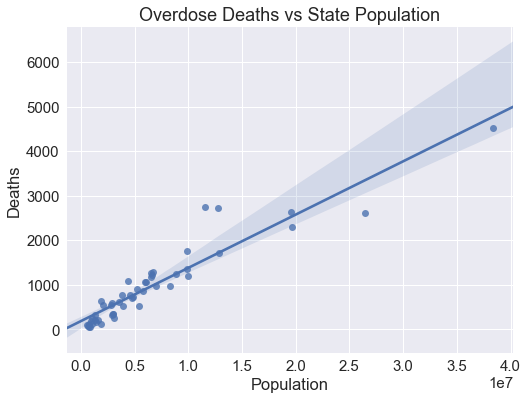

In [18]:
_ = plt.subplots(figsize=(8,6))
_ = sns.regplot(x='Population', y = 'Deaths', data = overdoses)
_ = plt.title('Overdose Deaths vs State Population')

However, that's not the whole story. If we look closely, we can see that linear regression model that is fit here seems to increase in error as population increases. 

If we plot the deaths rate per 100,000 state inhabitants versus the state population, we see that the reality of the situation is different

/home/rika/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/rika/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/home/rika/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



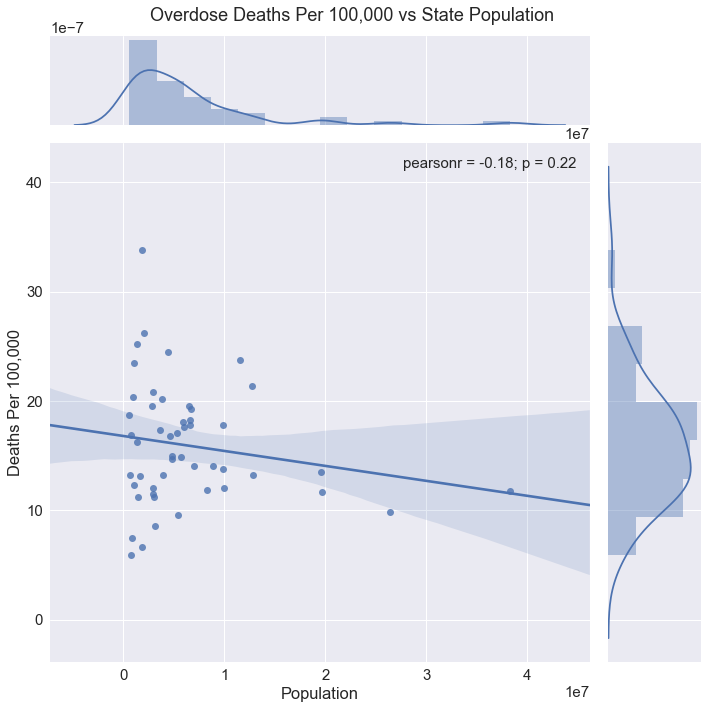

In [19]:
joint_pop = sns.jointplot(x='Population', y = 'Deaths Per 100,000', data = overdoses, size= 10, kind='reg')
plt.subplots_adjust(top=.94)
_ = joint_pop.fig.suptitle('Overdose Deaths Per 100,000 vs State Population', fontsize = 18)

The death rate per capita in each state actually doesn't seem to rely heavily on the state population. Some very populous states have relatively low overdose death rates relative to the overall population. And states that have higher than average opioid overdose death rates tend to be less populous in general. 

We see that increased rates of opioid overdose are localized to certain states. We do not have county data, but to further investigate the pattern of opioid deaths, this would be an essential further visualization. 

Finally, we must contextualize the opioid overdose death rates in terms of the overall death rates in the United States. 

In 2013, the 10 leading causes of death were: 

| Cause of Death | Age-adjusted Death Rate per 100,000 standard population |
| -------------- | ------------------------------------------------------- |
| Heart Disease  | 169.8 |
| Cancer         | 163.2 |
| Chronic lower respiratory disease | 42.1 |
| Unintentional Injuries | 39.4 |
| Stroke | 36.2 |
| Alzheimer's Disease | 23.5 |
| Diabetes | 21.2 |
| Influenza and pneumonia | 15.9 |
| Kidney Disease | 13.2 |
| Suicide | 12.6 |

[Source: CDC](https://www.cdc.gov/nchs/data/databriefs/db178.pdf)

Our death figures are not adjusted for age: however, a rough comparison figures is justified. The deaths per 100,000 that we observe for opioid overdoses exceeds the death rates for many leading causes of deaths in states such as West Virginia, New Mexico, New Hampshire, and Kentucky. The opioid overdose death rate exceeds the age-adjusted suicide death rate in 35 states. 

This indicates that death due opioid overdose is a significant public health concern and could fairly be termed an epidemic in some geographical areas of the United States. 

Death rates for opioid overdose per 100,000 in the 10 most seriously affected states:

In [20]:
death_rates= overdoses['Deaths Per 100,000'].sort_values(ascending=False)
death_rates[:10]

State
West Virginia    33.813226
New Mexico       26.231401
New Hampshire    25.236898
Kentucky         24.503475
Ohio             23.714852
Rhode Island     23.490006
Pennsylvania     21.387526
Utah             20.786853
Delaware         20.415901
Oklahoma         20.178841
Name: Deaths Per 100,000, dtype: float64

Number of states where death rate for opioid overdose exceeds age-adjusted death rate for suicide

In [21]:
len(death_rates.where(death_rates > 12.6).dropna())

35

## 3. Which variables available in the dataset influence state overdose rates? 

As we saw in the last section, there is a slight negative correlation between state population and overdose death rate. 

High unemployment rates are often quoted as a factor in drug epidemics. Let's see if that's the case here. 

/home/rika/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/rika/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/home/rika/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



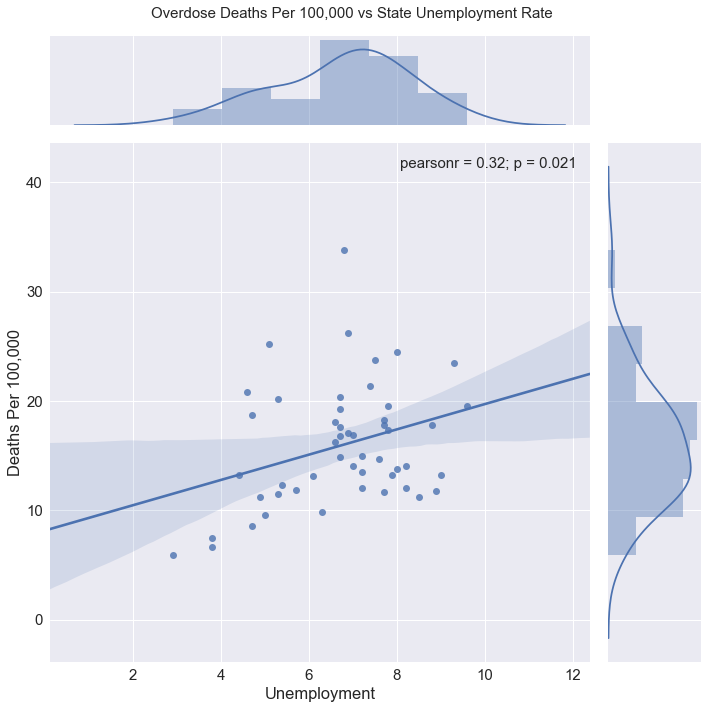

In [22]:
overdoses['Unemployment'] = unemployment['2013 rate']
joint_unemployment = sns.jointplot(x='Unemployment', y = 'Deaths Per 100,000', data = overdoses, size=10, kind='reg')
plt.subplots_adjust(top=.94)
_ = joint_unemployment.fig.suptitle('Overdose Deaths Per 100,000 vs State Unemployment Rate', fontsize=15)

There does appear to be a correlation between unemployment rates and state per capita death rates. We'll investigate this in more detail when we do some statistical inference on the dataset. 

## Question 4: Can we characterize provider specialties based on the drugs they prescribe in a year?

Is it possible to predict the specialty of a doctor based on information about the kinds of drugs they prescribe in a year? 

We use the number of each kind of tracked drug a given doctor prescribed in a year and try to see if we can distinguish between specialties

In [23]:
tracked_drugs = list(prescribers.columns)[5:-1]

def provider_drugs(npi, df= prescribers, track_list = tracked_drugs):
    '''
    Given a provider NPI, returns a list of the drugs the provider prescribed
    Grabs this info from the prescribers database unless otherwise instructed, 
    Grabs info about which drugs are being tracked from tracked_drugs (built from prescribers)
    unless otherwise noted. 
    
    With track_list = detected_opioids, this returns the (recognized) opioids the provdier has prescribed! :)
    '''
    row = df[prescribers.NPI==npi]
    all_drugs = row[track_list].transpose()
    all_drugs.columns = ['num_prescriptions']
    return list(all_drugs.iloc[all_drugs.num_prescriptions.nonzero()].index)

prescribers['prescribed_drugs'] = prescribers['NPI'].apply(provider_drugs)

def make_samples(val_list, col = 'Specialty', data_columns = tracked_drugs + ['Opioid.Prescriber'], 
                source_df = prescribers):
    '''
    INPUT: val_list, a list of values found in col 
           col, a string designating a column from source_df 
           data_columns, column names containing data we want in our sample
           source_df, the dataframe from which we're pulling data 
           
    '''
    samples = source_df[source_df[col].isin(val_list)][data_columns]
    return samples 

from sklearn.manifold import TSNE

In [31]:
# first try with two different prescribers...
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
tsne_model = TSNE(learning_rate = 200)
pipeline=Pipeline(steps = [('scale', scaler), ('tsne', tsne_model)])
sample_drugs = prescribers[prescribers.Specialty.isin(['Optometry', 'Vascular Surgery'])]['prescribed_drugs']
sample_drugs = list(set([drug for sublist in sample_drugs for drug in sublist]))
samples = make_samples(['Optometry', 'Vascular Surgery'], data_columns = sample_drugs + ['Specialty'])

transformed = pipeline.fit_transform(samples[sample_drugs])
xs = transformed[:,0]
ys = transformed[:,1]

trans_df = pd.DataFrame(transformed, columns = ['x', 'y'])
trans_df = trans_df.reset_index(drop=True)
sample_labels = samples.Specialty.reset_index(drop=True)
trans_df= pd.concat([trans_df, sample_labels], axis=1)

In [25]:
samples.head()

,TRAVATAN.Z,NABUMETONE,AZITHROMYCIN,HYDROCHLOROTHIAZIDE,POTASSIUM.CHLORIDE,ESCITALOPRAM.OXALATE,CILOSTAZOL,ONDANSETRON.ODT,PREDNISONE,FLUTICASONE.PROPIONATE,...,SULFAMETHOXAZOLE.TRIMETHOPRIM,AMLODIPINE.BESYLATE,MELOXICAM,FAMOTIDINE,PANTOPRAZOLE.SODIUM,CEFUROXIME,METHYLPREDNISOLONE,TRIAMCINOLONE.ACETONIDE,PRAVASTATIN.SODIUM,Specialty
8,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Optometry
49,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Optometry
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Optometry
144,298,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Optometry
344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Optometry


Each row corresponds to a specific provider. We only consider drugs that some optometrists or vascular surgeons have prescribed. We then use t-Stochastic Nearest-Neightbor Embedding (TSNE) to visualize our dataset. 

Points (which correspond to providers) that are near each other in the visualization are providers that are more similar to each other in terms of the number and types of drugs that they prescribe. 

TSNE is a useful technique for seeing structure in datasets. However, there are a few things to keep in mind: the relative distance between clusters is not usually very meaningful. Neither is cluster size. However, the existence of clusters is still an indicator of meaningful structure in the dataset. 


TSNE can be used with a variety of distance metrics. Since we are defining similarity here to mean that provider A and provider B prescribe the same drugs in about the same amounts, using a cosine metric is ideal. 

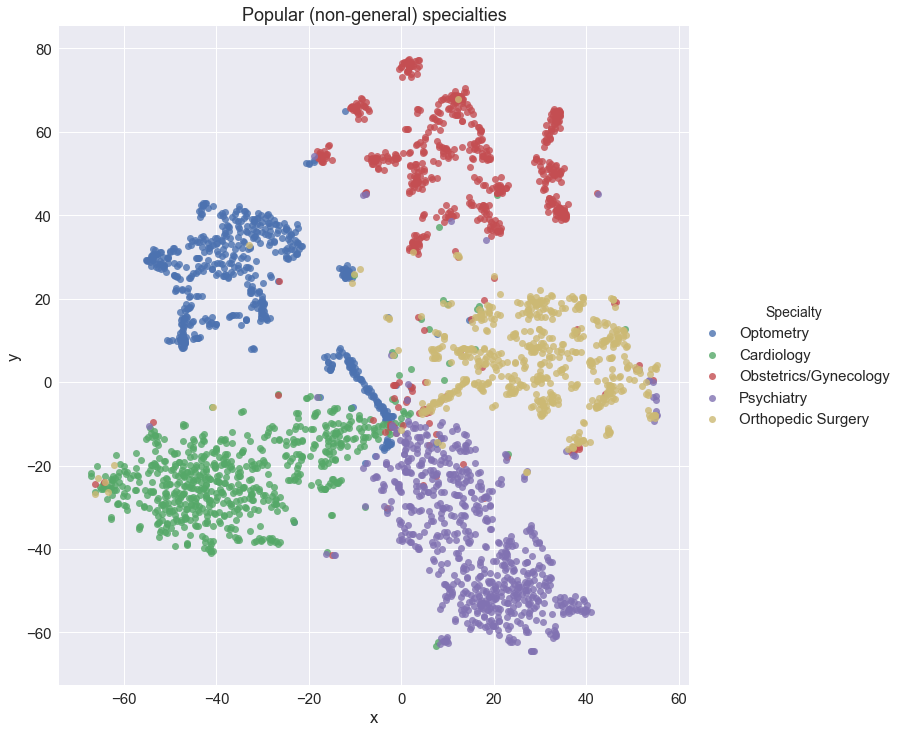

In [46]:
very_popular_specializations = ['Psychiatry', 'Cardiology', 'Obstetrics/Gynecology', 'Orthopedic Surgery', 'Optometry', 'Opthalmology']

samples_popular = make_samples(very_popular_specializations, data_columns = tracked_drugs + ['Specialty'])
scaler = StandardScaler()
tsne_model = TSNE(learning_rate = 300, perplexity=30, metric = 'cosine')
pipeline=Pipeline(steps = [('scale', scaler), ('tsne', tsne_model)])

transformed_popular = pipeline.fit_transform(samples_popular[tracked_drugs])
xs = transformed_popular[:,0]
ys = transformed_popular[:,1]

trans_df_popular = pd.DataFrame(transformed_popular, columns = ['x', 'y'])
trans_df_popular = trans_df_popular.reset_index(drop=True)
sample_labels_popular = samples_popular.Specialty.reset_index(drop=True)
trans_df_popular= pd.concat([trans_df_popular, sample_labels_popular], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df_popular, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Popular (non-general) specialties')

Based on the hypothesis that specialist providers are the most likely to have different prescribing patters, I picked five specialties that are likely to prescribe very different medications. The TSNE visualization indicates that the type of drugs most often prescribed in these specialties are distinct enough from one another that it should be possible to predict a doctor's specialty based on which drugs (and how much of them) they prescribe in a year with reasonable accuracy for these 5 disciplines.

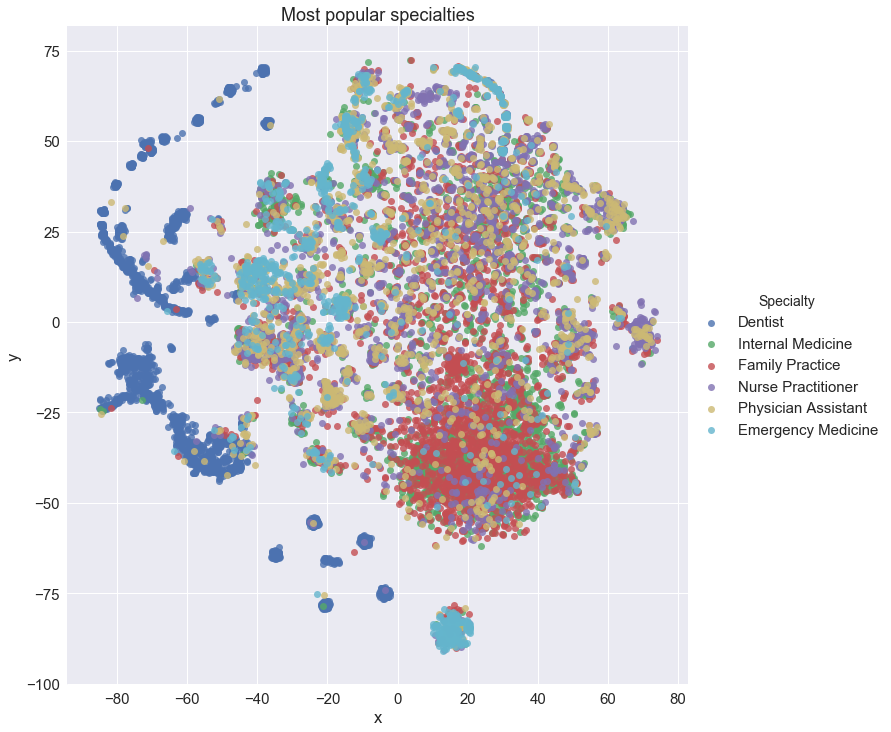

In [45]:
specialty_counts = prescribers.Specialty.value_counts()
most_popular = list(specialty_counts[specialty_counts > 1000].index)
samples = make_samples(most_popular, data_columns = tracked_drugs + ['Specialty'])

scaler = StandardScaler()
tsne_model = TSNE(learning_rate = 500, perplexity=50, metric = 'cosine')
pipeline=Pipeline(steps = [('scale', scaler), ('tsne', tsne_model)])

transformed = pipeline.fit_transform(samples[tracked_drugs])
xs = transformed[:,0]
ys = transformed[:,1]

trans_df = pd.DataFrame(transformed, columns = ['x', 'y'])
trans_df = trans_df.reset_index(drop=True)
sample_labels = samples.Specialty.reset_index(drop=True)
trans_df= pd.concat([trans_df, sample_labels], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Most popular specialties')

Next, I took a look at the most numerous specialties. These tend to be generalists such as internal medicine and family practice prescribers. Such providers are not very easy to tell apart based on the prescriptions they grant in a year, although dentists do appear to be easier to distinguish from the other 5 specialties. 

If we want to predict provider specialty from prescribed drugs, these visualizations that it should be possible for at least some specialties. In general, we should expect to be able to distinguish between doctors with specialties that are concentrated on a specific type of medicine with reasonable accuracy. On the other hand, there are some generalist specialties for which a classification task would not be advisable.